# Introduction.

These are some (modest) attempts at participating in Jigsaw's toxic comments classification problem. For now, I am not using any external data, only the training data given (which is limiting as it's a tiny dataset).

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
import keras
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re
import string
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import h5py
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

Using TensorFlow backend.
/Users/fmohamm/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load Data

In [2]:
df = pd.read_csv('../data/toxicity_annotated_comments.tsv', sep='\t')

In [3]:
df.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test


In [4]:
len(df)

159686

In [5]:
scores = pd.read_csv('../data/toxicity_annotations.tsv',  sep='\t')

In [6]:
scores.head(10)

,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0
5,2232.0,1508,0,1.0
6,2232.0,772,0,1.0
7,2232.0,680,0,0.0
8,2232.0,405,0,1.0
9,2232.0,4020,1,-1.0


In [7]:
scores.drop_duplicates(subset='rev_id', inplace=True)

In [8]:
len(scores)

159686

In [9]:
df = df.merge(scores, on='rev_id', how='inner')

In [10]:
len(df)

159686

In [11]:
df.head(10)

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,toxicity,toxicity_score
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,2002,True,article,random,train,723,0,0.0
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,2002,True,user,random,train,500,0,0.0
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test,2596,0,1.0
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,2002,True,article,random,train,1642,0,1.0
4,28959.0,Please relate the ozone hole to increases in c...,2002,True,article,random,test,202,0,1.0
5,35367.0,`:In an interpreted language your source code ...,2002,True,article,random,dev,1408,0,1.0
6,37330.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENI fixe...,2002,True,article,random,train,691,0,0.0
7,37346.0,`If they are ``indisputable`` then why does th...,2002,True,article,random,train,1108,0,0.0
8,37675.0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,dev,403,0,1.0
9,44377.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThe co...,2002,True,article,random,train,1927,0,2.0


In [12]:
df.drop(columns=['year', 'logged_in', 'split', 'ns', 'sample', 'worker_id'], inplace=True)

In [13]:
df.head(10)

,rev_id,comment,toxicity,toxicity_score
0,2232.0,This:NEWLINE_TOKEN:One can make an analogy in ...,0,0.0
1,4216.0,`NEWLINE_TOKENNEWLINE_TOKEN:Clarification for ...,0,0.0
2,8953.0,Elected or Electoral? JHK,0,1.0
3,26547.0,`This is such a fun entry. DevotchkaNEWLINE_...,0,1.0
4,28959.0,Please relate the ozone hole to increases in c...,0,1.0
5,35367.0,`:In an interpreted language your source code ...,0,1.0
6,37330.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENI fixe...,0,0.0
7,37346.0,`If they are ``indisputable`` then why does th...,0,0.0
8,37675.0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,0,1.0
9,44377.0,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThe co...,0,2.0


In [14]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def mr_clean(comment):
    comment = re.sub('NEWLINE_TOKEN', '', comment)
    comment = re_tok.sub('', comment)             # remove punctuation
    comment = re.sub('_', ' ', comment)
    comment = re.sub( '\s+', ' ', comment)
    comment = comment.strip()
    return comment

In [15]:
df['comment'] = df['comment'].apply(mr_clean)

In [16]:
df['comment'].head()

0    ThisOne can make an analogy in mathematical te...
1    Clarification for you and Zundarks right i sho...
2                             Elected or Electoral JHK
3    This is such a fun entry DevotchkaI once had a...
4    Please relate the ozone hole to increases in c...
Name: comment, dtype: object

In [17]:
#Create a list of profane words 
badlist1 = pd.read_table('../../data_bad_words/otherwise_bad_all_lang.txt', header=None)
badlist2 = pd.read_table('../../data_bad_words/profane1.txt', header=None, comment='#')
badlist1 = badlist1.values.flatten().tolist()
badlist2 = badlist2.values.flatten().tolist()
badlist = pd.Series(badlist1 + badlist2)
badlist = badlist.str.lower().drop_duplicates().reset_index(drop=True)
badlist = badlist.values.tolist()
badlist

['سكس',
 'طيز',
 'شرج',
 'لعق',
 'لحس',
 'مص',
 'تمص',
 'بيضان',
 'ثدي',
 'بز',
 'بزاز',
 'حلمة',
 'مفلقسة',
 'بظر',
 'كس',
 'فرج',
 'شهوة',
 'شاذ',
 'مبادل',
 'عاهرة',
 'جماع',
 'قضيب',
 'زب',
 'لوطي',
 'لواط',
 'سحاق',
 'سحاقية',
 'اغتصاب',
 'خنثي',
 'احتلام',
 'نيك',
 'متناك',
 'متناكة',
 'شرموطة',
 'عرص',
 'خول',
 'قحبة',
 'لبوةbordel',
 'buzna',
 'čumět',
 'čurák',
 'debil',
 'do piče',
 'do prdele',
 'dršťka',
 'držka',
 'flundra',
 'hajzl',
 'hovno',
 'chcanky',
 'chuj',
 'jebat',
 'kokot',
 'kokotina',
 'koňomrd',
 'kunda',
 'kurva',
 'mamrd',
 'mrdat',
 'mrdka',
 'mrdník',
 'oslošoust',
 'piča',
 'píčus',
 'píchat',
 'pizda',
 'prcat',
 'prdel',
 'prdelka',
 'sračka',
 'srát',
 'šoustat',
 'šulin',
 'vypíčenec',
 'zkurvit',
 'zkurvysyn',
 'zmrd',
 'žrát',
 'anus',
 'bøsserøv',
 'cock',
 'fisse',
 'fissehår',
 'fuck',
 'hestepik',
 'kussekryller',
 'lort',
 'luder',
 'pik',
 'pikhår',
 'pikslugeri',
 'piksutteri',
 'pis',
 'røv',
 'røvhul',
 'røvskæg',
 'røvspræke',
 'shit',
 '

In [18]:
import enchant
from fuzzywuzzy import process
from pandas import Series 

def containsAny(seq, aset):
    return bool(set(aset).intersection(seq))
    
def preprocess_toxic_comment_in_a_line(mycomment, badlist):
    mycomment_words = mycomment.split()
    d = enchant.Dict("en_US")
    num_toxic_word = 0
    curated_line = []
    for myword in mycomment_words:
        myword = myword[:30] #Truncate to 30 characters
        myword_len = len(myword)
        myword_lower = myword.lower()
        #Check if toxic word 
        if myword_lower in badlist:
            curated_line.append(myword)
            num_toxic_word += 1
            continue 
        #If myword in dictionary then simply add 
        if d.check(myword_lower): 
            curated_line.append(myword)
            continue 
        #Get fuzzy matches to the word
        matches = process.extract(myword_lower, badlist)
        if myword_len == 30:
            if matches[0][1] > 75: #Matching percent more than 75
                curated_line.append(matches[0][0])
                num_toxic_word += 1
                continue
        #If string contains any of the following characters then try to map to the closest 
        if containsAny(myword_lower, {'!', '@', '#', '$', '%', '^', '&', '*'}):
            closest_match = matches[0]
            for tup in matches[:5]:
                if len(tup[0]) == len(myword_lower):
                    closest_match = tup
                    break
            new_word =   closest_match[0]
            num_toxic_word += 1
            curated_line.append(new_word)
            continue
        #If everything fails. Keep as is 
        curated_line.append(myword)
    curated_line = ' '.join(curated_line)
    toxic_score_boost = np.true_divide(num_toxic_word, len(mycomment_words)) 
    return Series([curated_line, toxic_score_boost])

In [19]:
# mycomment = df['comment'].ix[3,:]
# mycomment = 'Fu$#youB@stardFu$#youB@stardFu$#youB@stardFu$#youB@stardFu$#youB@stardFu$#youB@stard'
# print(mycomment)
# preprocess_toxic_comment_in_a_line(mycomment, badlist)

In [ ]:
df[['comment', 'toxic_boost']] = df['comment'].apply(preprocess_toxic_comment_in_a_line, args = [badlist] )

In [ ]:
df

In [ ]:
df['toxic'] = df['toxicity_score'].apply(lambda x: int(x < 0))

In [ ]:
df.drop(columns=['toxicity', 'toxicity_score'], inplace=True)

In [ ]:
#df.sort_values(['toxic'], ascending=False, inplace=True)

In [ ]:
df[df['toxic']==1].head(10)

# Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split
y = df.toxic
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=101)

In [ ]:
len(X_train)

In [ ]:
len(X_test)

In [ ]:
X_train.to_csv('../data/toxic_train.tsv', sep='\t')
X_test.to_csv('../data/toxic_test.tsv', sep='\t')

# Pre-process

In [27]:
simple_tokens = X_train.comment.apply(gensim.utils.simple_preprocess)

In [28]:
phrases = gensim.models.phrases.Phrases(simple_tokens)
tokenizer = gensim.models.phrases.Phraser(phrases)

In [29]:
tokenized_text = list(tokenizer[simple_tokens])

In [30]:
tokenized_text[0]

['ed_boon',
 'said',
 'in',
 'an_interview',
 'that',
 'there',
 'would',
 'be',
 'at_least',
 'characters',
 'however',
 'dont_think',
 'we',
 'can',
 'report',
 'this',
 'because',
 'that',
 'was',
 'an',
 'estimate',
 'in',
 'early',
 'development',
 'like',
 'in',
 'march',
 'or',
 'something']

In [31]:
corpus_dict = gensim.corpora.dictionary.Dictionary(tokenized_text)

In [32]:
X_train.columns

Index(['rev_id', 'comment', 'toxic'], dtype='object')

In [33]:
TARGET_CLASSES = ['toxic']
targets = X_train[TARGET_CLASSES].values

In [34]:
targets

array([[0],
       [0],
       [0],
       ..., 
       [0],
       [0],
       [0]])

# Analysis

(0, 400)

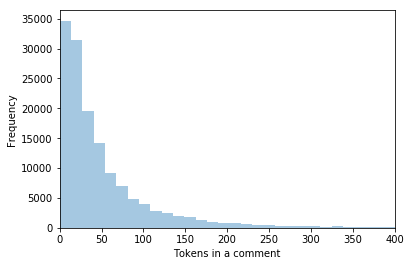

In [43]:
sns.distplot([len(doc) for doc in tokenized_text], bins=100, kde=False, label='Number of tokens per comment.')
plt.xlabel("Tokens in a comment")
plt.ylabel("Frequency")
plt.xlim((0, 400))

# Training word2vec on comment data.

In [44]:
word2vec = gensim.models.word2vec.Word2Vec(tokenized_text, window=5, size=100, min_count=2, workers=6)

In [45]:
word2vec.wv.most_similar('citation')

[('reference', 0.8324511647224426),
 ('source', 0.8086929321289062),
 ('ref', 0.7720947265625),
 ('references', 0.7694875001907349),
 ('citations', 0.7552413940429688),
 ('reliable_source', 0.7348667979240417),
 ('secondary_source', 0.7305512428283691),
 ('footnote', 0.7250741720199585),
 ('verification', 0.7163118124008179),
 ('sources', 0.7059152722358704)]

In [46]:
word2vec.wv.most_similar('stupid')

[('dumb', 0.844036340713501),
 ('pathetic', 0.8346757292747498),
 ('crazy', 0.8233659863471985),
 ('retarded', 0.7821276187896729),
 ('funny', 0.7751038074493408),
 ('sick', 0.7745219469070435),
 ('disgusting', 0.7631621360778809),
 ('ugly', 0.761038064956665),
 ('lazy', 0.7598941326141357),
 ('silly', 0.7505162954330444)]

# word2vec-based model

Aggregate word embeddings per comment (~ tf-idf weighted averaging), and use that as an input feature in a neural net with one hidden layer.

In [47]:
features = np.zeros((len(tokenized_text), word2vec.vector_size))
for i, tokens in enumerate(tokenized_text):
    tokens = [t for t in tokens if t in word2vec.wv.vocab]
    if tokens:
        features[i, :] = np.mean([word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens], axis=0)

In [48]:
#model = Sequential()
#model.add(Dense(256, activation='relu', input_shape=(word2vec.vector_size,)))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
#model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
#model.fit(features, targets, epochs=10, validation_split=0.1)

# Sequential models

Simply averaging embeddings across all terms in a comment loses interactions that can occur between words, and the importance of their position. Because of this, we will now experiment with position-aware models: LSTM and CNN.

In [50]:
# Note: shifting indices by 1 as index 0 will be used for padding.
docs = [[idx + 1 for idx in corpus_dict.doc2idx(doc)]  for doc in tokenized_text]

In [51]:
MAX_SEQ_LEN = 50
padded_docs = keras.preprocessing.sequence.pad_sequences(docs, maxlen=MAX_SEQ_LEN, truncating='post', value=0)

In [52]:
max_idx = max(c for d in docs for c in d)
max_idx

241649

In [53]:
embeddings = np.array([np.random.normal(size=word2vec.vector_size)]+ # for the '0' padding word
                      [word2vec.wv[corpus_dict[idx]]
                      if corpus_dict[idx] in word2vec.wv.vocab
                      else np.random.normal(size=word2vec.vector_size)
                      for idx in range(max_idx)])

## CNN

In [54]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPool1D, Flatten, BatchNormalization

model = Sequential()
model.add(Embedding(max_idx + 1, word2vec.vector_size, input_length=MAX_SEQ_LEN))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(52, 5, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(128, 3, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid',
                kernel_regularizer=keras.regularizers.l2(0.02)))
model.compile(Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
model.fit(padded_docs, targets, batch_size=512, epochs=20, validation_split=0.1)

Train on 129345 samples, validate on 14372 samples
Epoch 1/20
129345/129345 [==============================] - 136s 1ms/step - loss: 0.7663 - acc: 0.8653 - val_loss: 0.4417 - val_acc: 0.8569
Epoch 2/20
129345/129345 [==============================] - 137s 1ms/step - loss: 0.3009 - acc: 0.8997 - val_loss: 0.3915 - val_acc: 0.8655
Epoch 3/20
129345/129345 [==============================] - 136s 1ms/step - loss: 0.2385 - acc: 0.9189 - val_loss: 0.3708 - val_acc: 0.8890
Epoch 4/20
129345/129345 [==============================] - 126s 976us/step - loss: 0.1983 - acc: 0.9358 - val_loss: 0.3755 - val_acc: 0.8902
Epoch 5/20
129345/129345 [==============================] - 135s 1ms/step - loss: 0.1720 - acc: 0.9463 - val_loss: 0.4404 - val_acc: 0.8844
Epoch 6/20
129345/129345 [==============================] - 136s 1ms/step - loss: 0.1522 - acc: 0.9552 - val_loss: 0.4782 - val_acc: 0.8651
Epoch 7/20
129345/129345 [==============================] - 134s 1ms/step - loss: 0.1351 - acc: 0.9625 - va

# Save Model

In [56]:
model.save_weights('models/cnn_model.h5')

In [57]:
#model.load_weights('models/cnn_model.h5')

# Evaluation

In [58]:
def comment_to_sequential_input(comment):
    tokens = tokenizer[gensim.utils.simple_preprocess(comment)]
    t_ids = [corpus_dict.token2id[t] + 1 for t in tokens if t in word2vec.wv.vocab and t in corpus_dict.token2id]
    return keras.preprocessing.sequence.pad_sequences([t_ids], maxlen=MAX_SEQ_LEN)[0]

In [59]:
def predict(comment):
    test_input = [comment_to_sequential_input(comment).reshape(1, -1)]
    for target_class, score in zip(TARGET_CLASSES, model.predict(test_input)[0]):
        print("{}: {:.2f}%".format(target_class, score * 100))

In [61]:
comment = "Why are we having all these people from shithole countries come here?"
predict(comment)

toxic: 56.00%


In [65]:
comment = 'You suck, loser!'
predict(comment)

toxic: 99.10%


In [66]:
comment = "Now is the time for all good persons to come to the aid of their country"
predict(comment)

toxic: 2.35%


In [67]:
test_inputs = np.array([comment_to_sequential_input(doc) for doc in X_test.comment])

In [68]:
y_pred = model.predict_classes(test_inputs)

In [69]:
y_true = X_test.as_matrix(columns=['toxic'])

In [70]:
accuracy_score(y_true, y_pred)

0.86655394827478238

In [71]:
target_names = ['toxic']
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

      toxic       0.90      0.94      0.92     13612

avg / total       0.85      0.87      0.86     15969



/Users/jbatz/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 1
  .format(len(labels), len(target_names))


# Fin

In [65]:
spell('f11nd1')

'f11nd1'

In [80]:
# import Levenshtein
# !pip install fuzzywuzzy
from fuzzywuzzy import fuzz, process
# fuzz.partial_ratio('fuck', '))))0000fuck))')
process.extract('fukfukfuk', ['fuck', 'pics', 'f4ck', 'fuk'],limit = 1)

[('fuk', 90)]

In [57]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

FileNotFoundError: [Errno 2] No such file or directory: 'big.txt'